In [30]:
import pandas as pd
import numpy as np
import os
import datetime as dt
from datetime import datetime
import seaborn as sns
import matplotlib as plt
from scipy import stats
from scipy.stats import norm, ttest_ind

In [2]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [3]:
# Read data and change column "date" to datetime type
df_sales_detail = read_database('2022-04-01T12_df_sales_detail.csv')
df_sales_detail['date'] = pd.to_datetime(df_sales_detail['date'])

In [26]:
# Задание 1 решение
top_3_revenue = (
    df_sales_detail
    .groupby('good')['price'].sum()
    .sort_values()[-3:].index.tolist()
)
print('Ответ:', top_3_revenue)

Ответ: ['chicken bbq pizza', 'double pepperoni pizza', 'chefs pizza']


In [27]:
# Задание 2
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_web_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales['day'] = df_sales['date'].dt.date
df_s = df_sales.groupby(['user_id', 'date'], as_index=False).agg({'price':'sum'})
df_lg = df_web_logs.groupby(['user_id', 'date'], as_index=False).agg({'page':'count'})
df_full = df_s.merge(df_lg, how = 'left', on = 'user_id')
df_full['delta'] = df_full.date_x - df_full.date_y
df_full['delta_days'] = df_full.delta.dt.days
df_full_p = df_full[df_full.delta_days == 0]
df = df_full_p[df_full_p.delta.dt.seconds <= 7200]
df_final = df.groupby(['user_id', 'date_x'], as_index=False).agg({'delta':'max'})
round((df_final.delta.dt.seconds.mean() / 60),0)

In [31]:
# Задание 2 решение
from datetime import timedelta

# объединяем таблицы с покупками и логами по пользователям
# оставляем только user_id и времена
df = pd.merge(
    df_sales[['user_id', 'date']].rename(columns={'date': 'date_sale'}),
    df_web_logs[['user_id', 'date']].rename(columns={'date': 'date_web'}),
    on='user_id',
    how='inner'
)

# удаляем строки, в которых заход на сайт ранее 2 часов до покупки или после покупки
df = df[
    (df['date_web'] >= df['date_sale'] - timedelta(hours=2))
    & (df['date_web'] < df['date_sale'])
].copy()
# определяем время первого захода на сайт для покупки
df_first_web = df.groupby(['user_id', 'date_sale'])[['date_web']].min().reset_index()
# вычисляем время в секундах
df_first_web['delta'] = (df_first_web['date_sale'] - df_first_web['date_web']).dt.total_seconds()

# считаем среднее время и переводим в минуты
answer = round(df_first_web['delta'].mean() / 60)
print('answer:', answer)

In [18]:
# Задание 3
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales['month'] = df_sales['date'].dt.month
df = df_sales.query('month == 2 or month ==3').groupby(['user_id', 'month'], as_index=False).agg({'sale_id':'nunique'})
df_1 = df.groupby('user_id', as_index=False).agg({'month': 'count'})
df_1[df_1.month == 2].user_id.count() / df[df.month == 2].user_id.count()

In [ ]:
# Задание 3 Решение
# добавляем столбец с месяцем
df_sales['month'] = df_sales['date'].dt.month
# пользователи с покупкой в феврале
users_feb = df_sales[df_sales['month'] == 2]['user_id'].unique().tolist()
# пользователи с покупкой в марте
users_mar = df_sales[df_sales['month'] == 3]['user_id'].unique().tolist()
# пользователи с покупкой в феврале и марте
users_feb_mar = list(set(users_feb).intersection(set(users_mar)))

answer = len(users_feb_mar) / len(users_feb)
print('answer:', round(answer, 2))

In [10]:
# Задание 4
import pandas as pd

from datetime import datetime


class DataService:

    def __init__(self, table_name_2_table):
        """Класс, предоставляющий доступ к сырым данным.
        
        :param table_name_2_table (dict[str, pd.DataFrame]): словарь таблиц с данными.
            Пример, {
                'sales': pd.DataFrame({'sale_id': ['123', ...], ...}),
                ...
            }. 
        """
        self.table_name_2_table = table_name_2_table

    def get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        """Возвращает подмножество данных.

        :param table_name (str): название таблицы с данными.
        
        :param begin_date (datetime.datetime): дата начала интервала с данными.
            Пример, df[df['date'] >= begin_date].
            Если None, то фильтровать не нужно.
        :param end_date (None, datetime.datetime): дата окончания интервала с данными.
            Пример, df[df['date'] < end_date].
            Если None, то фильтровать не нужно.
        :param user_ids (None, list[str]): список user_id, по которым нужно предоставить данные.
            Пример, df[df['user_id'].isin(user_ids)].
            Если None, то фильтровать по user_id не нужно.
        :param columns (None, list[str]): список названий столбцов, по которым нужно предоставить данные.
            Пример, df[columns].
            Если None, то фильтровать по columns не нужно.

        :return df (pd.DataFrame): датафрейм с подмножеством данных.
        """
        # YOUR_CODE_HERE
        # table_name (str): название таблицы с данными. Так как в начале мы создаем словарь,
        # то, чтобы обратиться к датафрейму, нам нужно указать это же имя
        df = self.table_name_2_table[table_name]
        
        if begin_date:
            df = df[df['date'] >= begin_date]
            
        if end_date:
            df = df[df['date'] < end_date]
            
        if user_ids:
            df = df[df['user_id'].isin(user_ids)]
            
        if columns:
            df = df[columns]
        return df.copy()

def _chech_df(df, df_ideal, sort_by):
    assert isinstance(df, pd.DataFrame), 'Функция вернула не pd.DataFrame.'
    assert len(df) == len(df_ideal), 'Неверное количество строк.'
    assert len(df.T) == len(df_ideal.T), 'Неверное количество столбцов.'
    columns = df_ideal.columns
    assert df.columns.isin(columns).sum() == len(df.columns), 'Неверное название столбцов.'
    df = df[columns].sort_values(sort_by)
    df_ideal = df_ideal.sort_values(sort_by)
    assert df_ideal.equals(df), 'Итоговый датафрейм не совпадает с верным результатом.'


if __name__ == '__main__':
    table = pd.DataFrame({
        'date': [datetime(2022, 1, 5, 12,), datetime(2022, 1, 7, 12)],
        'user_id': ['1', '2'],
    })
    ideal_df = pd.DataFrame({
        'date': [datetime(2022, 1, 5, 12,)],
        'user_id': ['1'],
    })

    data_service = DataService({'table': table})
    res_df = data_service.get_data_subset('table', datetime(2022, 1, 1), datetime(2022, 1, 6))
    _chech_df(res_df, ideal_df, 'date')
    print('simple test passed')

simple test passed


In [ ]:
# Задание 4 решение 
import pandas as pd

from datetime import datetime


class DataService:

    def __init__(self, table_name_2_table):
        """Класс, предоставляющий доступ к сырым данным.
        
        :param table_name_2_table (dict[str, pd.DataFrame]): словарь таблиц с данными.
            Пример, {
                'sales': pd.DataFrame({'sale_id': ['123', ...], ...}),
                ...
            }. 
        """
        self.table_name_2_table = table_name_2_table

    def get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        """Возвращает подмножество данных.

        :param table_name (str): название таблицы с данными.
        :param begin_date (None, datetime.datetime): дата начала интервала с данными.
            Пример, df[df['date'] >= begin_date].
            Если None, то фильтровать не нужно.
        :param end_date (None, datetime.datetime): дата окончания интервала с данными.
            Пример, df[df['date'] < end_date].
            Если None, то фильтровать не нужно.
        :param user_ids (None, list[str]): список user_id, по которым нужно предоставить данные.
            Пример, df[df['user_id'].isin(user_ids)].
            Если None, то фильтровать по user_id не нужно.
        :param columns (None, list[str]): список названий столбцов, по которым нужно предоставить данные.
            Пример, df[columns].
            Если None, то фильтровать по columns не нужно.

        :return df (pd.DataFrame): датафрейм с подмножеством данных.
        """
        df = self.table_name_2_table[table_name]
        if begin_date:
            df = df[df['date'] >= begin_date]
        if end_date:
            df = df[df['date'] < end_date]
        if user_ids:
            df = df[df['user_id'].isin(user_ids)]
        if columns:
            df = df[columns]
        return df.copy()


In [218]:
# Задание 5
import pandas as pd

from datetime import datetime


class DataService:

    def __init__(self, table_name_2_table):
        self.table_name_2_table = table_name_2_table

    def get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        df = self.table_name_2_table[table_name]
        if begin_date:
            df = df[df['date'] >= begin_date]
        if end_date:
            df = df[df['date'] < end_date]
        if user_ids:
            df = df[df['user_id'].isin(user_ids)]
        if columns:
            df = df[columns]
        return df.copy()


class MetricsService:

    def __init__(self, data_service):
        """Класс для вычисления метрик.

        :param data_service (DataService): объект класса, предоставляющий доступ к данным.
        """
        self.data_service = data_service

    def _get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        """Возвращает часть таблицы с данными."""
        return self.data_service._get_data_subset(table_name, begin_date, end_date, user_ids, columns)

    def _calculate_response_time(self, begin_date, end_date, user_ids):
        """Вычисляет значения времени обработки запроса сервером.
        
        Нужно вернуть значения user_id и load_time из таблицы 'web-logs', отфильтрованные по date и user_id.
        Считаем, что каждый запрос независим, поэтому группировать по user_id не нужно.

        :param begin_date, end_date (datetime): период времени, за который нужно считать значения.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        # YOUR_CODE_HERE
        df_response_time = self.data_service.table_name_2_table['web-logs']
        if begin_date:
            df_response_time = df_response_time[df_response_time['date'] >= begin_date]
        if end_date:
            df_response_time = df_response_time[df_response_time['date'] < end_date]
        if user_ids:
            df_response_time = df_response_time[df_response_time['user_id'].isin(user_ids)]
        df_response_time = df_response_time.rename(columns={'load_time':'metric'})
        return df_response_time[['user_id', 'metric']].copy()
        

    def _calculate_revenue_web(self, begin_date, end_date, user_ids):
        """Вычисляет значения выручки с пользователя за указанный период
        для заходивших на сайт в указанный период.

        Эти данные нужны для экспериментов на сайте, когда в эксперимент попадают только те, кто заходил на сайт.
        
        Нужно вернуть значения user_id и выручки (sum(price)).
        Данные о ценах в таблице 'sales'. Данные о заходивших на сайт в таблице 'web-logs'.
        Если пользователь зашёл на сайт и ничего не купил, его суммарная стоимость покупок равна нулю.
        Для каждого user_id должно быть ровно одно значение.

        :param begin_date, end_date (datetime): период времени, за который нужно считать значения.
            Также за этот период времени нужно выбирать пользователей, которые заходили на сайт.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        # YOUR_CODE_HERE
        # Загрузка данных            
        df_web_1 = self.data_service.table_name_2_table['web-logs']
        df_sales_1 = self.data_service.table_name_2_table['sales']
        if user_ids:
            df_web_1 = df_web_1[df_web_1['user_id'].isin(user_ids)]
            df_sales_1 = df_sales_1[df_sales_1['user_id'].isin(user_ids)]
            
        user_id = df_web_1[(df_web_1['date'] >= begin_date) & (df_web_1['date'] < end_date)].user_id.unique().tolist()
        df_users = (pd.DataFrame(df_web_1[(df_web_1['date'] >= begin_date)
                            & (df_web_1['date'] < end_date)]['user_id']
                    .unique())
              .rename(columns={0:'user_id'}))
        df_sales = (df_sales_1[(df_sales_1['user_id'].isin(user_id))
                               & (df_sales_1['date'] >= begin_date)
                               & (df_sales_1['date'] < end_date)]
                    .groupby('user_id', as_index=False)
                    .agg({'price':'sum'})
                    .rename(columns={'price': 'metric'}))
        df_revenue_web = df_sales.merge(df_users, how='outer', on='user_id').fillna({'metric':0})
        return df_revenue_web[['user_id', 'metric']].copy()

    def _calculate_revenue_all(self, begin_date, end_date, user_ids):
        """Вычисляет значения выручки с пользователя за указанный период
        для заходивших на сайт до end_date.

        Эти данные нужны, например, для экспериментов с рассылкой по email,
        когда в эксперимент попадают те, кто когда-либо оставил нам свои данные.
        
        Нужно вернуть значения user_id и выручки (sum(price)).
        Данные о ценах в таблице 'sales'. Данные о заходивших на сайт в таблице 'web-logs'.
        Если пользователь ничего не купил за указанный период, его суммарная стоимость покупок равна нулю.
        Для каждого user_id должно быть ровно одно значение.

        :param begin_date, end_date (datetime): период времени, за который нужно считать значения.
            Нужно выбирать пользователей, которые хотя бы раз заходили на сайт до end_date.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        # YOUR_CODE_HERE
        df_web_1 = self.data_service.table_name_2_table['web-logs']
        df_sales_1 = self.data_service.table_name_2_table['sales']
        if user_ids:
            df_web_1 = df_web_1[df_web_1['user_id'].isin(user_ids)]
            df_sales_1 = df_sales_1[df_sales_1['user_id'].isin(user_ids)]
            
        user_id = df_web_1[df_web_1['date'] < end_date].user_id.unique().tolist()
        df_users = (pd.DataFrame(df_web_1[df_web_1['date'] < end_date]['user_id']
                    .unique())
              .rename(columns={0:'user_id'}))
        df_sales = (df_sales_1[(df_sales_1['user_id'].isin(user_id))
                               & (df_sales_1['date'] < end_date)]
                    .groupby('user_id', as_index=False)
                    .agg({'price':'sum'})
                    .rename(columns={'price': 'metric'}))
        df_revenue_all = df_sales.merge(df_users, how='outer', on='user_id').fillna({'metric':0})
        return df_revenue_all[['user_id', 'metric']].copy()

    def calculate_metric(self, metric_name, begin_date, end_date, user_ids=None):
        """Считает значения для вычисления метрик.

        :param metric_name (str): название метрики
        :param begin_date (datetime): дата начала периода (включая границу)
        :param end_date (datetime): дата окончания периода (не включая границу)
        :param user_ids (list[str], None): список пользователей.
            Если None, то вычисляет значения для всех пользователей.
        :return df: columns=['user_id', 'metric']
        """
        if metric_name == 'response time':
            return self._calculate_response_time(begin_date, end_date, user_ids)
        elif metric_name == 'revenue (web)':
            return self._calculate_revenue_web(begin_date, end_date, user_ids)
        elif metric_name == 'revenue (all)':
            return self._calculate_revenue_all(begin_date, end_date, user_ids)
        else:
            raise ValueError('Wrong metric name')

def _chech_df(df, df_ideal, sort_by, reindex=False, set_dtypes=False):
    assert isinstance(df, pd.DataFrame), 'Функция вернула не pd.DataFrame.'
    assert len(df) == len(df_ideal), 'Неверное количество строк.'
    assert len(df.T) == len(df_ideal.T), 'Неверное количество столбцов.'
    columns = df_ideal.columns
    assert df.columns.isin(columns).sum() == len(df.columns), 'Неверное название столбцов.'
    df = df[columns].sort_values(sort_by)
    df_ideal = df_ideal.sort_values(sort_by)
    if reindex:
        df_ideal.index = range(len(df_ideal))
        df.index = range(len(df))
    if set_dtypes:
        for column, dtype in df_ideal.dtypes.to_dict().items():
            df[column] = df[column].astype(dtype)
    assert df_ideal.equals(df), 'Итоговый датафрейм не совпадает с верным результатом.'


if __name__ == '__main__':
    df_sales = pd.DataFrame({
        'sale_id': [1, 2, 3],
        'date': [datetime(2022, 3, day, 11) for day in range(11, 14)],
        'price': [1100, 900, 1500],
        'user_id': ['1', '2', '1'],
    })
    df_web_logs = pd.DataFrame({
        'date': [datetime(2022, 3, day, 11) for day in range(10, 14)],
        'load_time': [80.8, 90.1, 15.8, 19.7],
        'user_id': ['3', '1', '2', '1'],
    })
    begin_date = datetime(2022, 3, 11, 9)
    end_date = datetime(2022, 4, 11, 9)

    ideal_response_time = pd.DataFrame({'user_id': ['1', '2', '1'], 'metric': [90.1, 15.8, 19.7],})
    ideal_revenue_web = pd.DataFrame({'user_id': ['1', '2'], 'metric': [2600., 900.],})
    ideal_revenue_all = pd.DataFrame({'user_id': ['1', '2', '3'], 'metric': [2600., 900., 0.],})

    data_service = DataService({'sales': df_sales, 'web-logs': df_web_logs})
    metrics_service = MetricsService(data_service)

    df_response_time = metrics_service.calculate_metric('response time', begin_date, end_date)
    df_revenue_web = metrics_service.calculate_metric('revenue (web)', begin_date, end_date)
    df_revenue_all = metrics_service.calculate_metric('revenue (all)', begin_date, end_date)

     _chech_df(df_response_time, ideal_response_time, ['user_id', 'metric'], True, True)
     _chech_df(df_revenue_web, ideal_revenue_web, ['user_id', 'metric'], True, True)
     _chech_df(df_revenue_all, ideal_revenue_all, ['user_id', 'metric'], True, True)
     print('simple test passed')

In [220]:
# Задание 5 решение 
import pandas as pd

from datetime import datetime


class DataService:

    def __init__(self, table_name_2_table):
        self.table_name_2_table = table_name_2_table

    def get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        df = self.table_name_2_table[table_name]
        if begin_date:
            df = df[df['date'] >= begin_date]
        if end_date:
            df = df[df['date'] < end_date]
        if user_ids:
            df = df[df['user_id'].isin(user_ids)]
        if columns:
            df = df[columns]
        return df.copy()


class MetricsService:

    def __init__(self, data_service):
        """Класс для вычисления метрик.

        :param data_service (DataService): объект класса, предоставляющий доступ к данным.
        """
        self.data_service = data_service

    def _get_data_subset(self, table_name, begin_date, end_date, user_ids=None, columns=None):
        """Возвращает часть таблицы с данными."""
        return self.data_service.get_data_subset(table_name, begin_date, end_date, user_ids, columns)

    def _calculate_response_time(self, begin_date, end_date, user_ids):
        """Вычисляет значения времени обработки запроса сервером.
        
        Нужно вернуть значения user_id и load_time из таблицы 'web-logs', отфильтрованные по date и user_id.
        Считаем, что каждый запрос независим, поэтому группировать по user_id не нужно.

        :param begin_date, end_date (datetime): период времени, за который нужно считать значения.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        return (
            self._get_data_subset('web-logs', begin_date, end_date, user_ids, ['user_id', 'load_time'])
            .rename(columns={'load_time': 'metric'})
            [['user_id', 'metric']]
        )

    def _calculate_revenue_web(self, begin_date, end_date, user_ids):
        """Вычисляет значения выручки с пользователя за указанный период
        для заходивших на сайт в указанный период.

        Эти данные нужны для экспериментов на сайте, когда в эксперимент попадают только те, кто заходил на сайт.
        
        Нужно вернуть значения user_id и выручки (sum(price)).
        Данные о ценах в таблице 'sales'. Данные о заходивших на сайт в таблице 'web-logs'.
        Если пользователь зашёл на сайт и ничего не купил, его суммарная стоимость покупок равна нулю.
        Для каждого user_id должно быть ровно одно значение.

        :param begin_date, end_date (datetime): период времени, за который нужно считать значения.
            Также за этот период времени нужно выбирать пользователей, которые заходили на сайт.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        user_ids_ = (
            self._get_data_subset('web-logs', begin_date, end_date, user_ids, ['user_id'])
            ['user_id'].unique()
        )
        df = (
            self._get_data_subset('sales', begin_date, end_date, user_ids, ['user_id', 'price'])
            .groupby('user_id')[['price']].sum().reset_index() 
            .rename(columns={'price': 'metric'})
        )
        df = pd.merge(pd.DataFrame({'user_id': user_ids_}), df, on='user_id', how='left').fillna(0)
        return df[['user_id', 'metric']]

    def _calculate_revenue_all(self, begin_date, end_date, user_ids):
        """Вычисляет значения выручки с пользователя за указанный период
        для заходивших на сайт до end_date.

        Эти данные нужны, например, для экспериментов с рассылкой по email,
        когда в эксперимент попадают те, кто когда-либо оставил нам свои данные.
        
        Нужно вернуть значения user_id и выручки (sum(price)).
        Данные о ценах в таблице 'sales'. Данные о заходивших на сайт в таблице 'web-logs'.
        Если пользователь ничего не купил за указанный период, его суммарная стоимость покупок равна нулю.
        Для каждого user_id должно быть ровно одно значение.

        :param begin_date, end_date (datetime): период времени, за который нужно считать значения.
            Нужно выбирать пользователей, которые хотя бы раз заходили на сайт до end_date.
        :param user_id (None, list[str]): id пользователей, по которым нужно отфильтровать полученные значения.
        
        :return (pd.DataFrame): датафрейм с двумя столбцами ['user_id', 'metric']
        """
        user_ids_ = (
            self._get_data_subset('web-logs', None, end_date, user_ids, ['user_id'])
            ['user_id'].unique()
        )
        df = (
            self._get_data_subset('sales', begin_date, end_date, user_ids, ['user_id', 'price'])
            .groupby('user_id')[['price']].sum().reset_index() 
            .rename(columns={'price': 'metric'})
        )
        df = pd.merge(pd.DataFrame({'user_id': user_ids_}), df, on='user_id', how='left').fillna(0)
        return df[['user_id', 'metric']]

    def calculate_metric(self, metric_name, begin_date, end_date, user_ids=None):
        """Считает значения для вычисления метрик.

        :param metric_name (str): название метрики
        :param begin_date (datetime): дата начала периода (включая границу)
        :param end_date (datetime): дата окончания периода (не включая границу)
        :param user_ids (list[str], None): список пользователей.
            Если None, то вычисляет значения для всех пользователей.
        :return df: columns=['user_id', 'metric']
        """
        if metric_name == 'response time':
            return self._calculate_response_time(begin_date, end_date, user_ids)
        elif metric_name == 'revenue (web)':
            return self._calculate_revenue_web(begin_date, end_date, user_ids)
        elif metric_name == 'revenue (all)':
            return self._calculate_revenue_all(begin_date, end_date, user_ids)
        else:
            raise ValueError('Wrong metric name')


def _chech_df(df, df_ideal, sort_by, reindex=False, set_dtypes=False):
    assert isinstance(df, pd.DataFrame), 'Функция вернула не pd.DataFrame.'
    assert len(df) == len(df_ideal), 'Неверное количество строк.'
    assert len(df.T) == len(df_ideal.T), 'Неверное количество столбцов.'
    columns = df_ideal.columns
    assert df.columns.isin(columns).sum() == len(df.columns), 'Неверное название столбцов.'
    df = df[columns].sort_values(sort_by)
    df_ideal = df_ideal.sort_values(sort_by)
    if reindex:
        df_ideal.index = range(len(df_ideal))
        df.index = range(len(df))
    if set_dtypes:
        for column, dtype in df_ideal.dtypes.to_dict().items():
            df[column] = df[column].astype(dtype)
    assert df_ideal.equals(df), 'Итоговый датафрейм не совпадает с верным результатом.'


if __name__ == '__main__':
    df_sales = pd.DataFrame({
        'sale_id': [1, 2, 3],
        'date': [datetime(2022, 3, day, 11) for day in range(11, 14)],
        'price': [1100, 900, 1500],
        'user_id': ['1', '2', '1'],
    })
    df_web_logs = pd.DataFrame({
        'date': [datetime(2022, 3, day, 11) for day in range(10, 14)],
        'load_time': [80.8, 90.1, 15.8, 19.7],
        'user_id': ['3', '1', '2', '1'],
    })
    begin_date = datetime(2022, 3, 11, 9)
    end_date = datetime(2022, 4, 11, 9)

    ideal_response_time = pd.DataFrame({'user_id': ['1', '2', '1'], 'metric': [90.1, 15.8, 19.7],})
    ideal_revenue_web = pd.DataFrame({'user_id': ['1', '2'], 'metric': [2600., 900.],})
    ideal_revenue_all = pd.DataFrame({'user_id': ['1', '2', '3'], 'metric': [2600., 900., 0.],})

    data_service = DataService({'sales': df_sales, 'web-logs': df_web_logs})
    metrics_service = MetricsService(data_service)

    df_response_time = metrics_service.calculate_metric('response time', begin_date, end_date)
    df_revenue_web = metrics_service.calculate_metric('revenue (web)', begin_date, end_date)
    df_revenue_all = metrics_service.calculate_metric('revenue (all)', begin_date, end_date)

    _chech_df(df_response_time, ideal_response_time, ['user_id', 'metric'], True, True)
    _chech_df(df_revenue_web, ideal_revenue_web, ['user_id', 'metric'], True, True)
    _chech_df(df_revenue_all, ideal_revenue_all, ['user_id', 'metric'], True, True)
    print('simple test passed')


simple test passed


In [76]:
df_a = np.random.normal(loc=1000, scale=100, size=50)
df_b = np.random.normal(loc=1000, scale=100, size=50)
df_c = np.random.normal(loc=1050, scale=100, size=50)

In [77]:
stats.ttest_ind(df_a, df_b)

Ttest_indResult(statistic=-0.6830705239184199, pvalue=0.4961739603594266)

In [78]:
stats.ttest_ind(df_b, df_c)

Ttest_indResult(statistic=-1.9289362561682997, pvalue=0.05663194035680911)

In [79]:
stats.ttest_ind(df_a, df_c)

Ttest_indResult(statistic=-2.8945759592971987, pvalue=0.004680420726204914)

In [47]:
df_a = np.random.normal(loc=1000, scale=100, size=(1000, 50))
df_b = np.random.normal(loc=1000, scale=100, size=(1000, 50))
df_c = np.random.normal(loc=1050, scale=100, size=(1000, 50))

In [48]:
mean_a = []
mean_b = []
mean_c = []
for i in df_a:
    mean_a.append(i.mean())
for i in df_b:
    mean_b.append(i.mean())
for i in df_c:
    mean_c.append(i.mean())
mean_a = pd.DataFrame(mean_a).rename(columns={0: 'mean_a'})
mean_b = pd.DataFrame(mean_b).rename(columns={0: 'mean_b'})
mean_c = pd.DataFrame(mean_c).rename(columns={0: 'mean_c'})

In [71]:
df_full = pd.concat([mean_a, mean_b, mean_c], axis=1)
df_full['diff_ba'] = df_full.mean_b - df_full.mean_a
df_full['diff_ca'] = df_full.mean_c - df_full.mean_a
alfa = 40

In [72]:
print(f'Ошибка I рода {df_full[abs(df_full.diff_ba) > alfa].diff_ba.count() / 1000}')

Ошибка I рода 0.051


In [73]:
print(f'Ошибка II рода {df_full[abs(df_full.diff_ca) < alfa].diff_ca.count() / 1000}')

Ошибка II рода 0.297


In [52]:
df_full[abs(df_full.diff_ba) > 20]

,mean_a,mean_b,mean_c,diff_ba,diff_ca
3,1021.355938,1000.914450,1047.580593,-20.441488,26.224655
5,1018.652371,995.514883,1037.022780,-23.137488,18.370408
8,1011.447647,982.522007,1052.223967,-28.925639,40.776320
12,1010.975501,974.042658,1045.492710,-36.932843,34.517209
14,999.895894,1024.189829,1045.508863,24.293935,45.612969
...,...,...,...,...,...
991,971.271962,996.498456,1050.549349,25.226494,79.277386
992,1007.456311,962.249850,1068.396429,-45.206461,60.940118
993,986.218245,1031.765774,1042.769682,45.547529,56.551437
997,1026.452712,1002.651833,1045.498911,-23.800879,19.046199


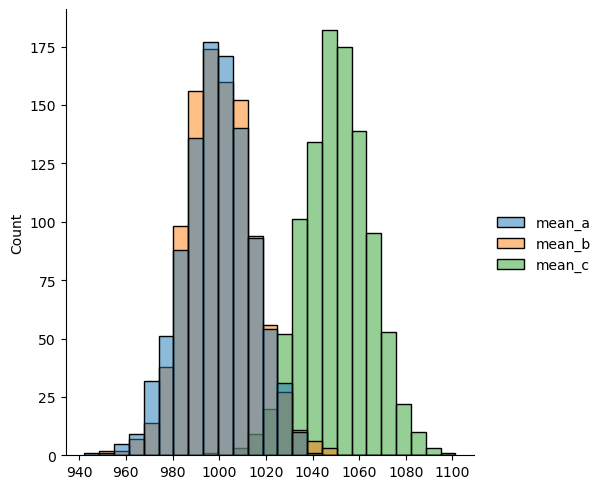

In [59]:
sns.displot(df_full[['mean_a', 'mean_b', 'mean_c']])

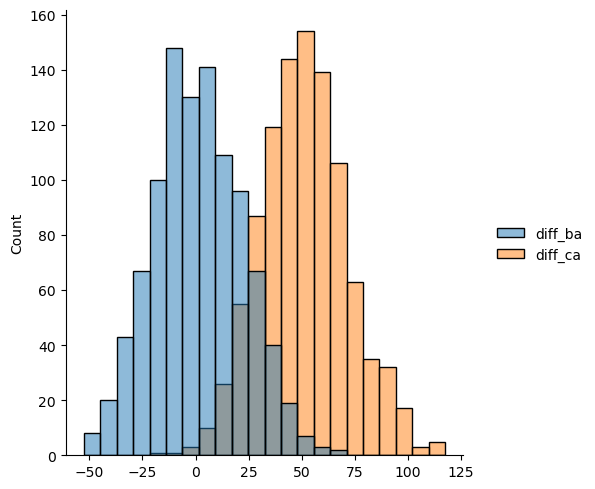

In [70]:
sns.displot(df_full[['diff_ba', 'diff_ca']])

In [5]:
# 02/02/2023 lesson 2.1
# Read data and change column "date" to datetime type
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_users = read_database('experiment_users.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

In [6]:
# считаем значения метрики
begin_date = datetime(2022, 3, 16)
end_date = datetime(2022, 3, 23)
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .reset_index()  
)
df = pd.merge(df_users, df_metrics, on='user_id', how='left').fillna(0)
data_control = df[df['pilot'] == 0]['price']
data_pilot = df[df['pilot'] == 1]['price']
stats.ttest_ind(data_control, data_pilot)

In [15]:
df_users_reg = df_sales.groupby('user_id', as_index=False).agg({'sale_id':'nunique'}).query('sale_id >=2').user_id.tolist()
df_day_mean = df_sales[df_sales['user_id'].isin(df_users_reg)][['user_id', 'date']].sort_values(['user_id', 'date'])
df_day_mean['date_y'] = df_day_mean.groupby('user_id').date.shift(-1)
df_day_mean['diff_d'] = df_day_mean.date_y - df_day_mean.date
df_day_mean['diff_days'] = df_day_mean.diff_d.dt.days
df_day_mean[df_day_mean.diff_days.notnull()].diff_days.mean()

In [ ]:
# для каждого пользователя считаем количество покупок, дату первой и последней покупки
df = df_sales.groupby('user_id')[['date']].agg(['count', 'min', 'max'])
df.columns = [x[1] for x in df.columns]
# оставляем пользователей с 2 и более покупок
df = df[df['count'] >= 2]
# количество секунд между первой и последней покупкой
df['delta'] = (df['max'] - df['min']).dt.total_seconds()
# суммарное время между покупками
sum_delta = df['delta'].sum()
# суммарное количество периодов между покупками
count_periods = df['count'].sum() - len(df)
# среднее = суммарное время / количество периодов
answer = sum_delta / count_periods / 3600 / 24
print('answer:', int(round(answer)))

In [69]:
pip install pydantic

     ---------------------------------------- 2.2/2.2 MB 172.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [70]:
import numpy as np
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента."""
    statistical_test: str


class ExperimentsService:

    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Применяет статтест, возвращает pvalue.

        :param metrics_a_group (np.array): массив значений метрик группы A
        :param metrics_a_group (np.array): массив значений метрик группы B
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        if design.statistical_test == 'ttest':
            # YOUR_CODE_HERE
            return stats.ttest_ind(metrics_a_group, metrics_b_group).pvalue
        else:
            raise ValueError('Неверный design.statistical_test')

In [71]:
class ExperimentsService:

    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Применяет статтест, возвращает pvalue.
        
        :param metrics_a_group (np.array): массив значений метрик группы A
        :param metrics_a_group (np.array): массив значений метрик группы B
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        if design.statistical_test == 'ttest':
            _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
            return pvalue
        else:
            raise ValueError('Неверный design.statistical_test')

simple test passed


In [5]:
# 8/05/2023 lesson 3
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


2022-02-04 10:00:24
2022-04-01 11:59:51
(203847, 6)


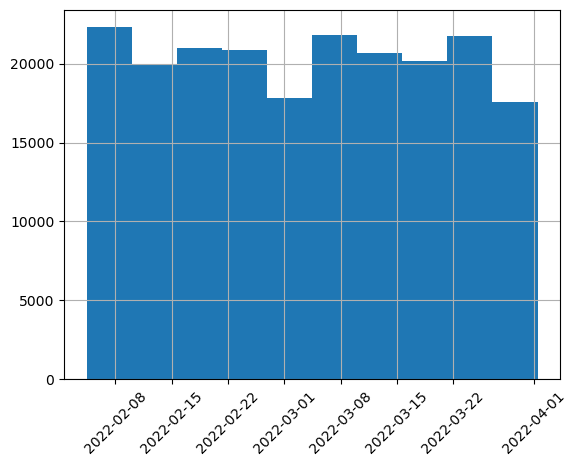

In [6]:
print(df_sales['date'].min())
print(df_sales['date'].max())
print(df_sales.shape)
df_sales['date'].hist(xrot=45);

In [13]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [28]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size
def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [95]:
df_sales_hist = df_sales[
    (df_sales['date'] >= datetime(2022, 2, 21))
    & (df_sales['date'] < datetime(2022, 2, 28))
]
df_sales_hist.shape

(25347, 6)

In [98]:
alpha = 0.05
beta = 0.1
epsilon = 20



mean = df_sales_hist.groupby(['user_id'])['price'].sum().mean()
std = df_sales_hist.groupby(['user_id'])['price'].sum().std()
eff = (mean+epsilon)/mean
sample_size = get_sample_size_abs(20, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = get_sample_size_arb(mean, std, eff=eff, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')
print(f'sample_size_round = {round(sample_size, -1)}')

sample_size = 34571
sample_size = 34571
sample_size_round = 34570


In [99]:
mde = get_minimal_determinable_effect(std, df_sales_hist.shape[0] // 2, alpha=alpha, beta=beta)
print(f'mde = {np.round(mde, 0)}')

mde = 33.0
